## Loading Chest X-Ray Images Data

In [0]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
!unzip chest_xray.zip

Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUM

## Importing the packages

In [0]:
# Importing the packages

import matplotlib.pyplot as plt
import numpy as np

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf


## Reading the images

In [0]:
batch_size=8
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
        'chest_xray/train',
        target_size=(128, 128),
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        'chest_xray/val',
        target_size=(128, 128),
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
# Run the for loop once

for image_batch, label_batch in train_generator:
  print("Image Batch Shape: ",image_batch.shape)
  print("Label Batch Shape: ", label_batch.shape)
  break

Image Batch Shape:  (8, 128, 128, 3)
Label Batch Shape:  (8, 2)


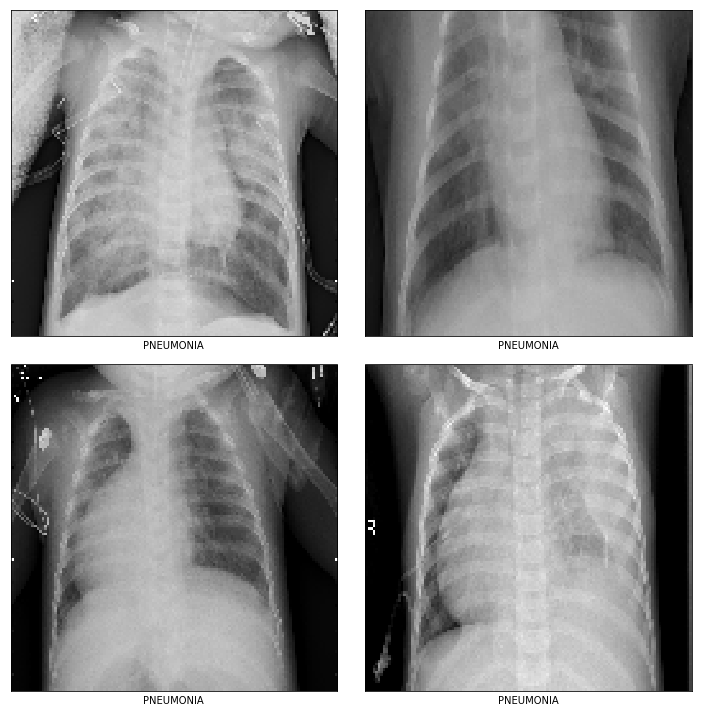

In [0]:
x,y = train_generator.next()

keys = train_generator.class_indices.keys()

plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = x[i]
  label = y[i]
  index = np.argmax(label)
  plt.imshow(image, cmap = plt.cm.binary)
  plt.xlabel(list(keys)[index])

plt.tight_layout()
plt.show()

## Building the model

In [0]:
# clear the current tensorflow graph and create new one
tf.keras.backend.clear_session()

#call the inception resnet pretrained model

model_resnet = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False, input_shape=(128,128,3))
last_layer = model_resnet.output

In [0]:
#freeze the weights of the model till layer 120
for layer in model_resnet.layers:
	layer.trainable = False

In [0]:
last_layer

<tf.Tensor 'mixed10/Identity:0' shape=(None, 2, 2, 2048) dtype=float32>

In [0]:
### Flatten the last layer
x = tf.keras.layers.Flatten()(last_layer)
#x = x(last_layer)
x = tf.keras.layers.Dropout(0.1)(x)

# add fully-connected & dropout layers
x = tf.keras.layers.Dense(256, activation='relu')(x)   ##try with larger number of neurons 
x = tf.keras.layers.Dense(512, activation='relu')(x)   ##try with larger number of neurons

x = tf.keras.layers.Dropout(0.1)(x)

n_classes=train_generator.num_classes
# a softmax layer for 2 classes
out_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = tf.keras.Model(inputs=model_resnet.input, outputs=out_layer)


In [0]:
len(model.layers)

317

In [0]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Model Training


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

batch_size = 8

# checkpointer = ModelCheckpoint(filepath="./tmp/transfer_learning/weights.hdf5", verbose=2, save_best_only=True)
# tensorboard = TensorBoard(log_dir='./tmp/transfer_learning/tensorboard/')


fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(train_generator.samples) // batch_size,
        epochs=10,     # Try with 100
        validation_data=validation_generator,
        validation_steps= int(validation_generator.samples) // batch_size,        
        verbose=2)
        #callbacks=[checkpointer, tensorboard])

Epoch 1/10
652/652 - 283s - loss: 0.3776 - accuracy: 0.8349 - val_loss: 2.0801 - val_accuracy: 0.6250
Epoch 2/10
652/652 - 271s - loss: 0.3016 - accuracy: 0.8708 - val_loss: 0.9315 - val_accuracy: 0.6875
Epoch 3/10
652/652 - 272s - loss: 0.2711 - accuracy: 0.8838 - val_loss: 0.8313 - val_accuracy: 0.7500
Epoch 4/10
652/652 - 270s - loss: 0.2684 - accuracy: 0.8873 - val_loss: 3.4713 - val_accuracy: 0.6250
Epoch 5/10
652/652 - 270s - loss: 0.2618 - accuracy: 0.8905 - val_loss: 1.6569 - val_accuracy: 0.6875
Epoch 6/10
652/652 - 270s - loss: 0.2464 - accuracy: 0.8953 - val_loss: 1.6502 - val_accuracy: 0.6250
Epoch 7/10
652/652 - 270s - loss: 0.2436 - accuracy: 0.8992 - val_loss: 2.4533 - val_accuracy: 0.6250
Epoch 8/10
652/652 - 271s - loss: 0.2366 - accuracy: 0.9013 - val_loss: 2.1797 - val_accuracy: 0.6250
Epoch 9/10
652/652 - 269s - loss: 0.2434 - accuracy: 0.9028 - val_loss: 0.9057 - val_accuracy: 0.6875
Epoch 10/10
652/652 - 267s - loss: 0.2381 - accuracy: 0.9055 - val_loss: 1.6158 - 

In [0]:
## Making Prediction

In [0]:
# Making predictions on test data

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
      rescale=1./255.)

test_generator = test_datagen.flow_from_directory(
        'chest_xray/test',
        target_size=(180, 180),
        batch_size=8,
        class_mode='categorical',
        shuffle=False
)


Found 624 images belonging to 2 classes.


In [0]:
result = model.predict_generator(test_generator)

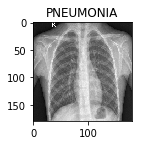

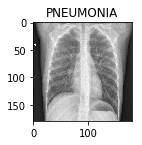

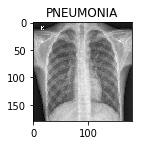

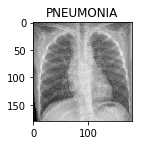

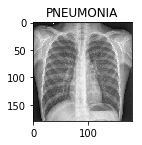

In [0]:
x,y = test_generator.next()
for i in range(0,5):
    image = x[i]
    title = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(np.argmax(result[i]))]
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    plt.title(title)
    plt.show()